In [18]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\XL892PG\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\XL892PG\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


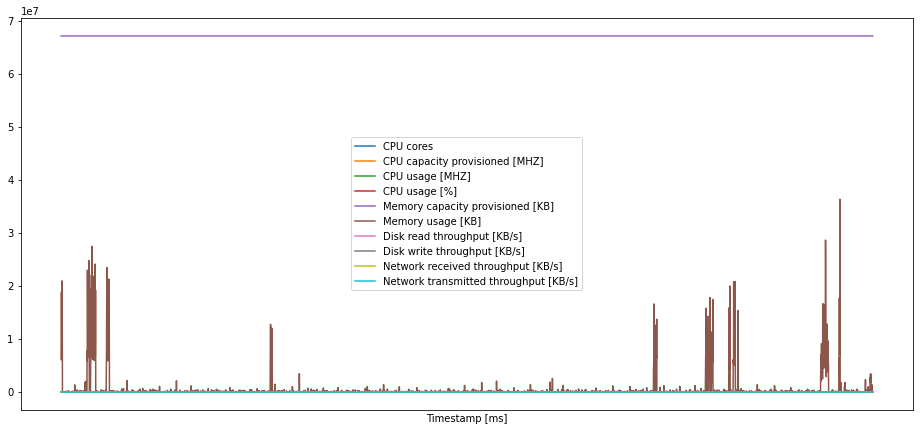

In [19]:
# let's load the dataset

df = pd.read_csv("./1.csv", ";\t")
df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'])
df = df.set_index('Timestamp [ms]')
df.plot(figsize=(16,8))
plt.show()

In [20]:
df.drop('CPU cores', inplace=True, axis=1)
df.drop('CPU usage [%]', inplace=True, axis=1)
df.drop('CPU capacity provisioned [MHZ]', inplace=True, axis=1)
df.drop('Memory capacity provisioned [KB]', inplace=True, axis=1)
df.drop('Memory usage [KB]', inplace=True, axis=1)
df.drop('Disk read throughput [KB/s]', inplace=True, axis=1)
df.drop('Disk write throughput [KB/s]', inplace=True, axis=1)
df.drop('Network received throughput [KB/s]', inplace=True, axis=1)
df.drop('Network transmitted throughput [KB/s]', inplace=True, axis=1)

In [21]:
df.head()
x = df.iloc[0:10]

In [22]:
# create train test split
train_length = round(len(df)*0.8)
test_length = len(df) - train_length
train = df.iloc[0:train_length]
test = df.iloc[train_length:]

In [23]:
# let's scale the values of the dataset
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [24]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [25]:
TIME_STEPS = 100
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags=TIME_STEPS)
X_test, y_test = train_generator(test, n_lags=TIME_STEPS)

In [26]:
print(X_train.shape)

(6806, 100, 1)


# Let's build a dense network and test it out

In [29]:
# define the keras model
model_NN = tf.keras.Sequential()
model_NN.add(tf.keras.layers.Dense(32, input_dim=100, activation='relu'))
model_NN.add(tf.keras.layers.Dense(32, activation='relu'))
model_NN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [30]:
model_NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                3232      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_NN.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [32]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [33]:
callbacks = [es, lr_red]
history = model_NN.fit(X_train, y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/200
20/20 [==============================] - 1s 9ms/step - loss: 0.4720 - val_loss: 0.4479 - lr: 0.0010
Epoch 2/200
20/20 [==============================] - 0s 3ms/step - loss: 0.4191 - val_loss: 0.3811 - lr: 0.0010
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3361 - val_loss: 0.2779 - lr: 0.0010
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.2226 - val_loss: 0.1607 - lr: 0.0010
Epoch 5/200
20/20 [==============================] - 0s 3ms/step - loss: 0.1193 - val_loss: 0.0821 - lr: 0.0010
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0488 - lr: 0.0010
Epoch 7/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.0363 - lr: 0.0010
Epoch 8/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0304 - val_loss: 0.0306 - lr: 0.0010
Epoch 9/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0277 - lr:

In [34]:
# sayyiv le modele when done
model_NN.save('./test_model_NN')

INFO:tensorflow:Assets written to: ./test_model_NN\assets


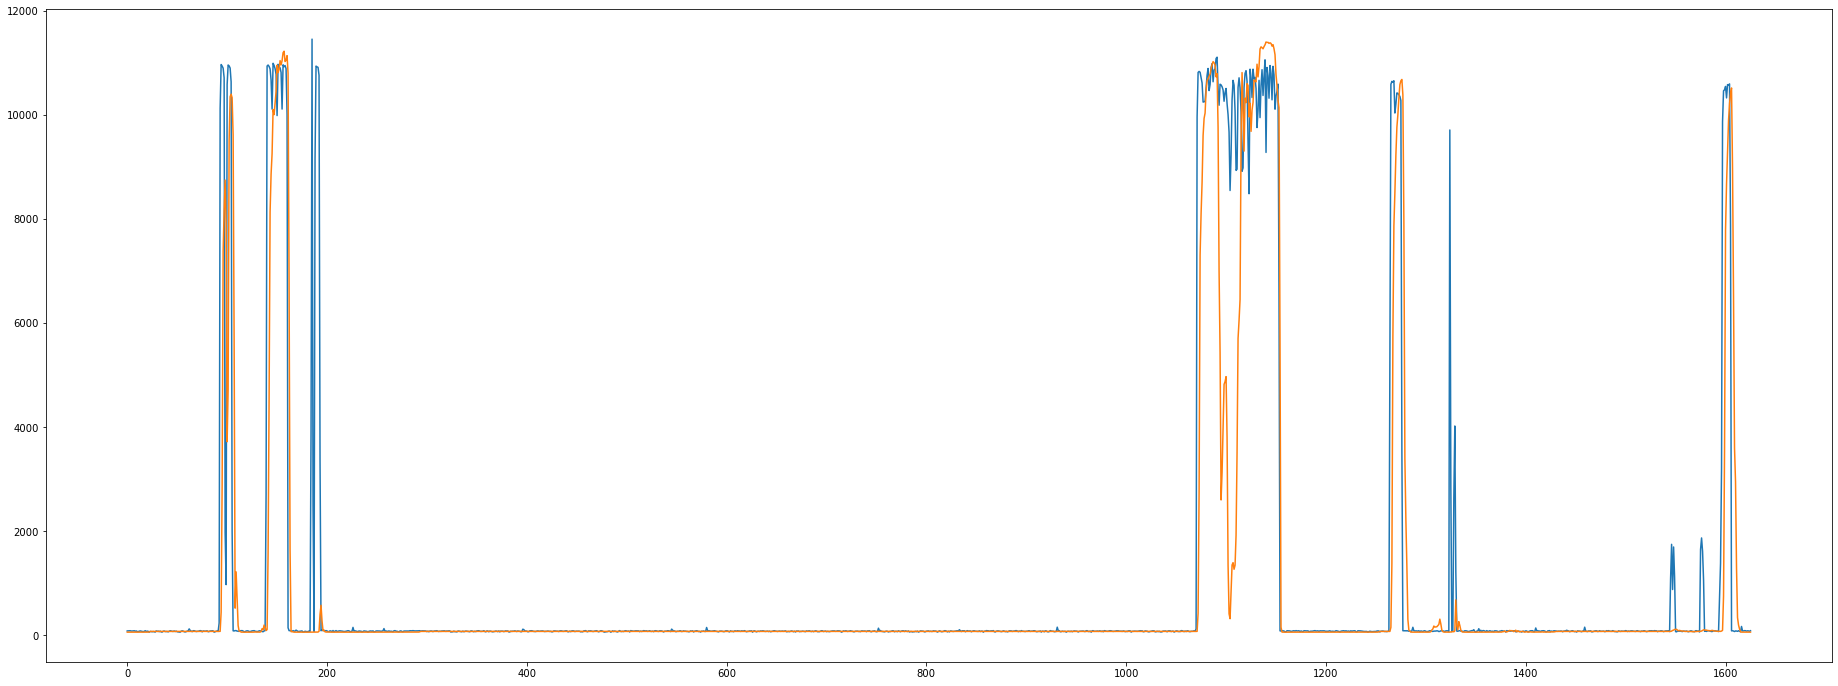

In [35]:
preds = model_NN.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [36]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 1651.00 RMSE
Test Score: 19.867803 MAE
Test Score: 88.796536 MAPE


# Let's build an LSTM model

In [37]:
# let's build the lstm model
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(512, return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_lstm.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [39]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [40]:
callbacks = [es, lr_red]
history = model_lstm.fit(X_train, y_train, epochs=100, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/100
20/20 [==============================] - 79s 4s/step - loss: 0.0351 - val_loss: 0.0278 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 99s 5s/step - loss: 0.0234 - val_loss: 0.0206 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 94s 5s/step - loss: 0.0210 - val_loss: 0.0189 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 118s 6s/step - loss: 0.0163 - val_loss: 0.0231 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 128s 7s/step - loss: 0.0086 - val_loss: 0.0189 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 114s 6s/step - loss: 0.0169 - val_loss: 0.0173 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 121s 6s/step - loss: 0.0149 - val_loss: 0.0240 - lr: 0.0010
Epoch 8/100
20/20 [==============================] - 102s 5s/step - loss: 0.0100 - val_loss: 0.0187 - lr: 0.0010
Epoch 9/100
20/20 [==============================] - 99s 5s/step - loss: 0.0175 - val_loss: 0.0170 

In [41]:
# sayyiv le modele when done
model_lstm.save('./test_model_LSTM')

INFO:tensorflow:Assets written to: ./test_model_LSTM\assets


INFO:tensorflow:Assets written to: ./test_model_LSTM\assets


dict_keys(['loss', 'val_loss', 'lr'])


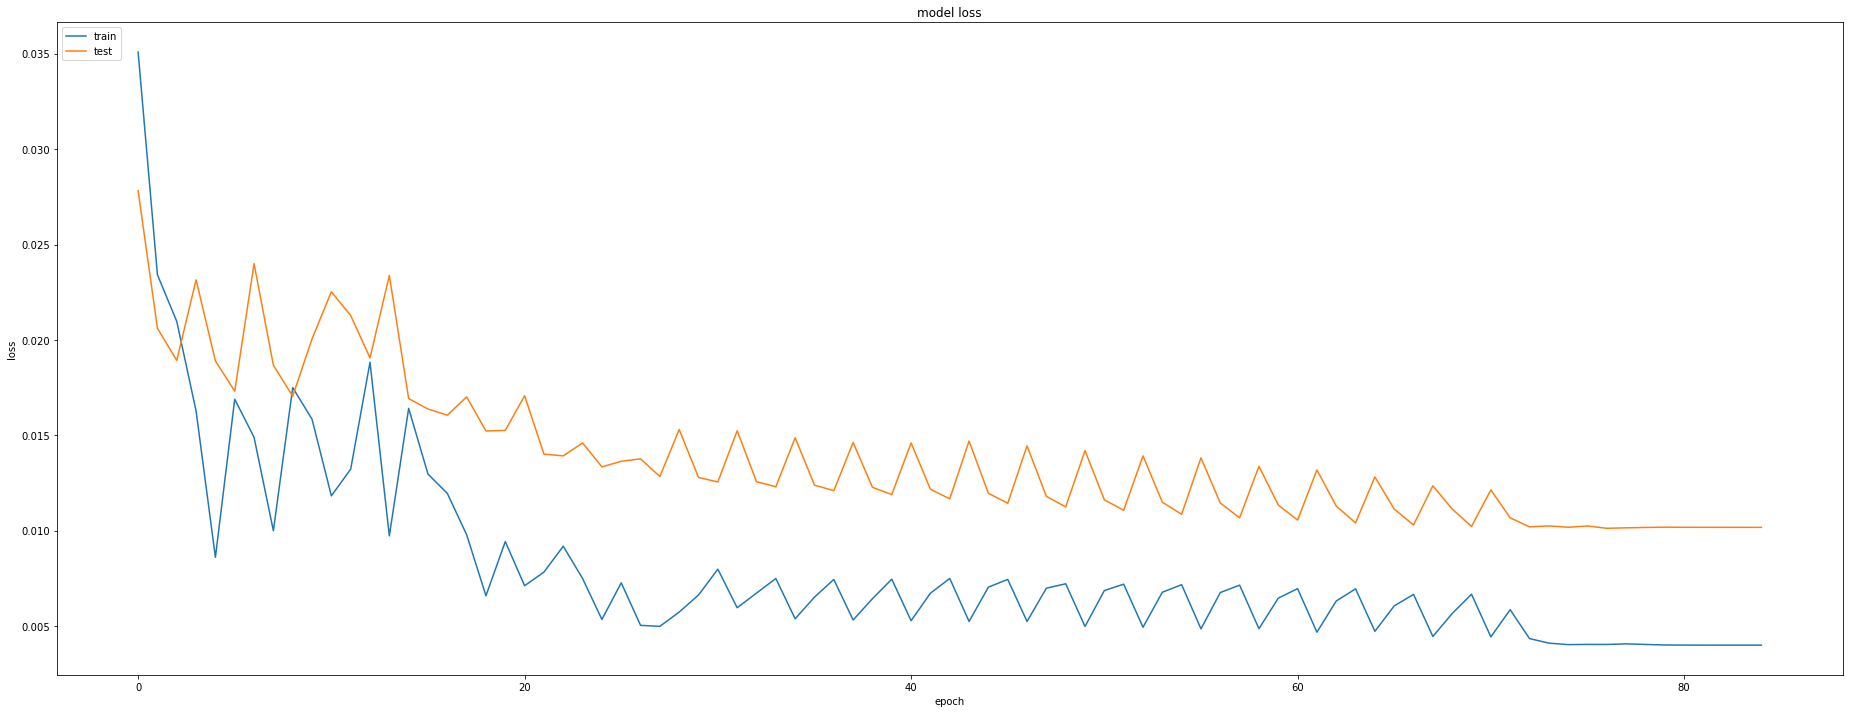

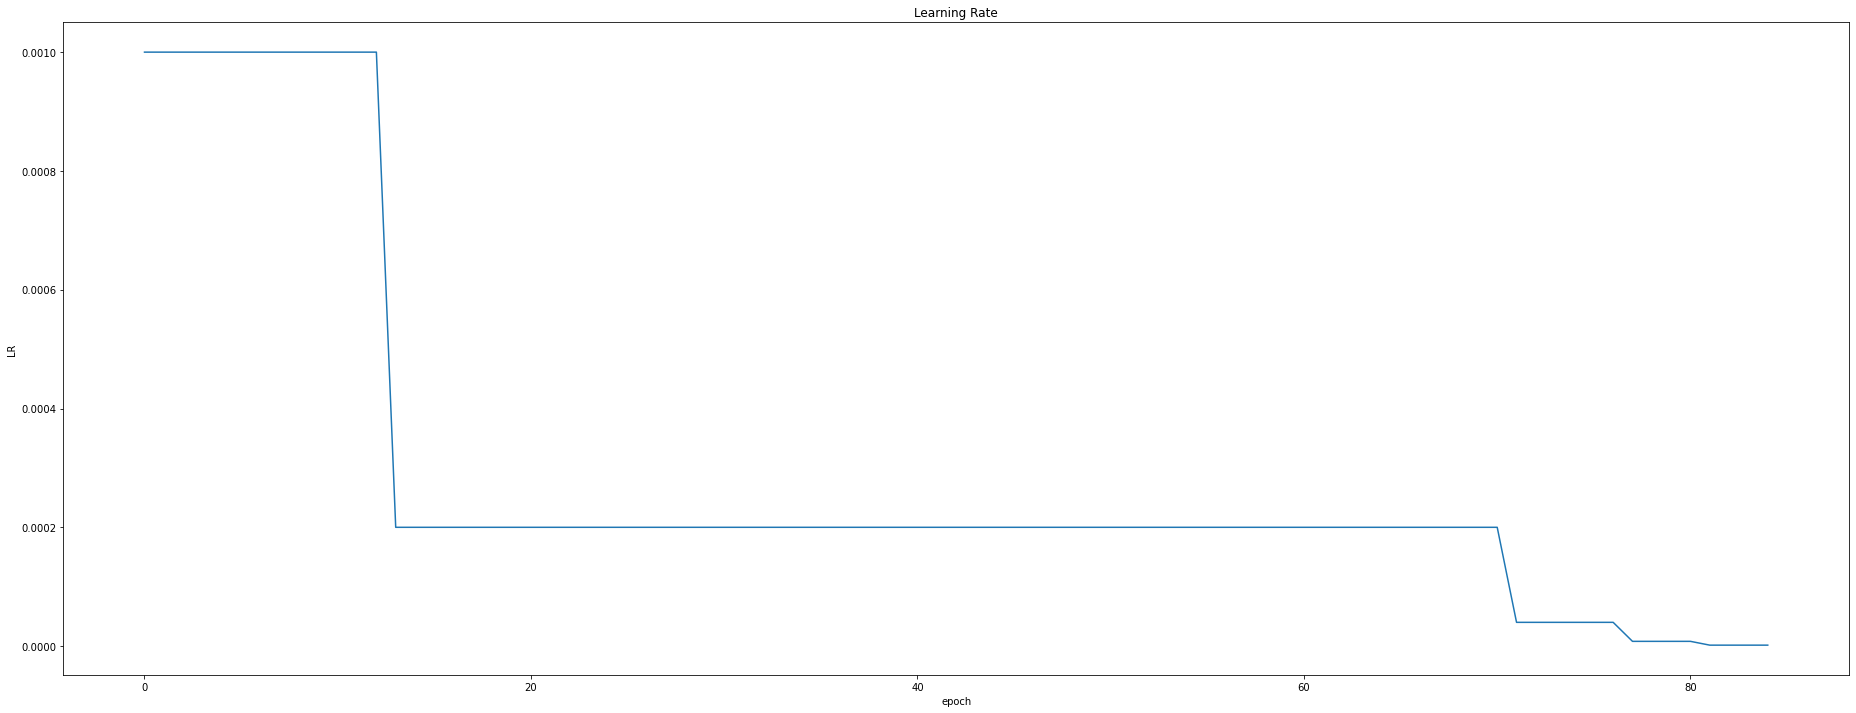

In [42]:
# try drawing the losses and the scores just to see where we are heading towards
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# why not also draw out the learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

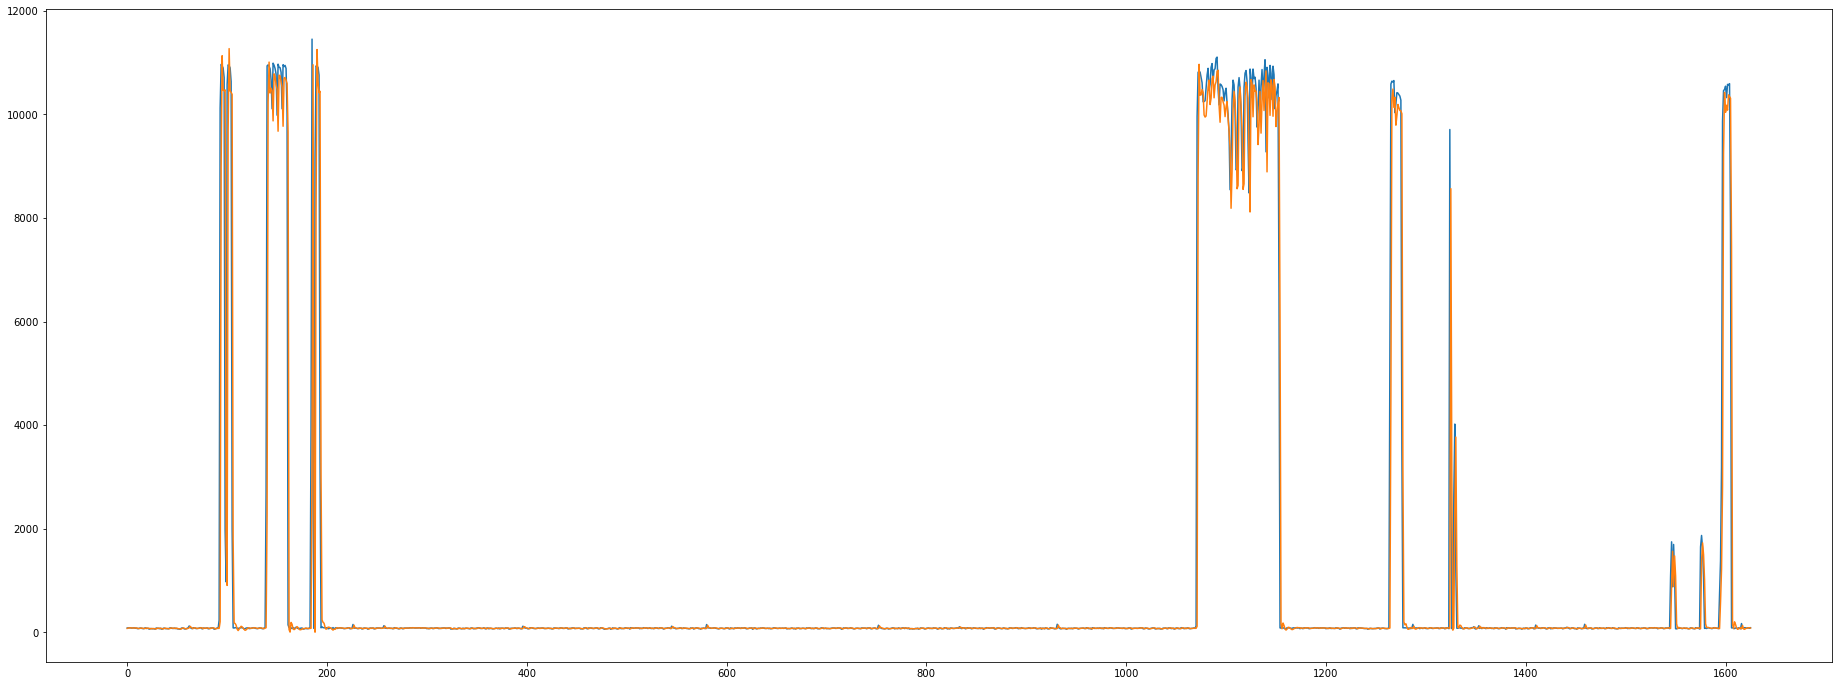

In [43]:
preds = model_lstm.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test)
PredY = pd.DataFrame(preds)

plot_max = plt.figure(1)
plt.plot(TestY)
plt.plot(PredY)
plt.show()

In [44]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 933.55 RMSE
Test Score: 13.032973 MAE
Test Score: 39.640802 MAPE


# Let's try to implement a GRU

In [45]:
# let's build the lstm model
# return sequences?? -> 
model_GRU = tf.keras.models.Sequential()
model_GRU.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], 1),return_sequences=True))
model_GRU.add(tf.keras.layers.GRU(512, return_sequences=False))
model_GRU.add(tf.keras.layers.Dense(1))
model_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 512)          791040    
                                                                 
 gru_1 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,367,489
Trainable params: 2,367,489
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_GRU.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [47]:
callbacks = [es, lr_red]
history = model_GRU.fit(X_train, y_train, epochs=100, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/100
20/20 [==============================] - 60s 3s/step - loss: 0.0458 - val_loss: 0.0222 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 54s 3s/step - loss: 0.0217 - val_loss: 0.0164 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 54s 3s/step - loss: 0.0162 - val_loss: 0.0336 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 53s 3s/step - loss: 0.0170 - val_loss: 0.0226 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 55s 3s/step - loss: 0.0206 - val_loss: 0.0189 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 0.0176
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 54s 3s/step - loss: 0.0176 - val_loss: 0.0166 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 55s 3s/step - loss: 0.0108 - val_loss: 0.0169 - lr: 2.0000e-04
Epoch 8/100
20/20 [==============================] - 55s 3s/step - 

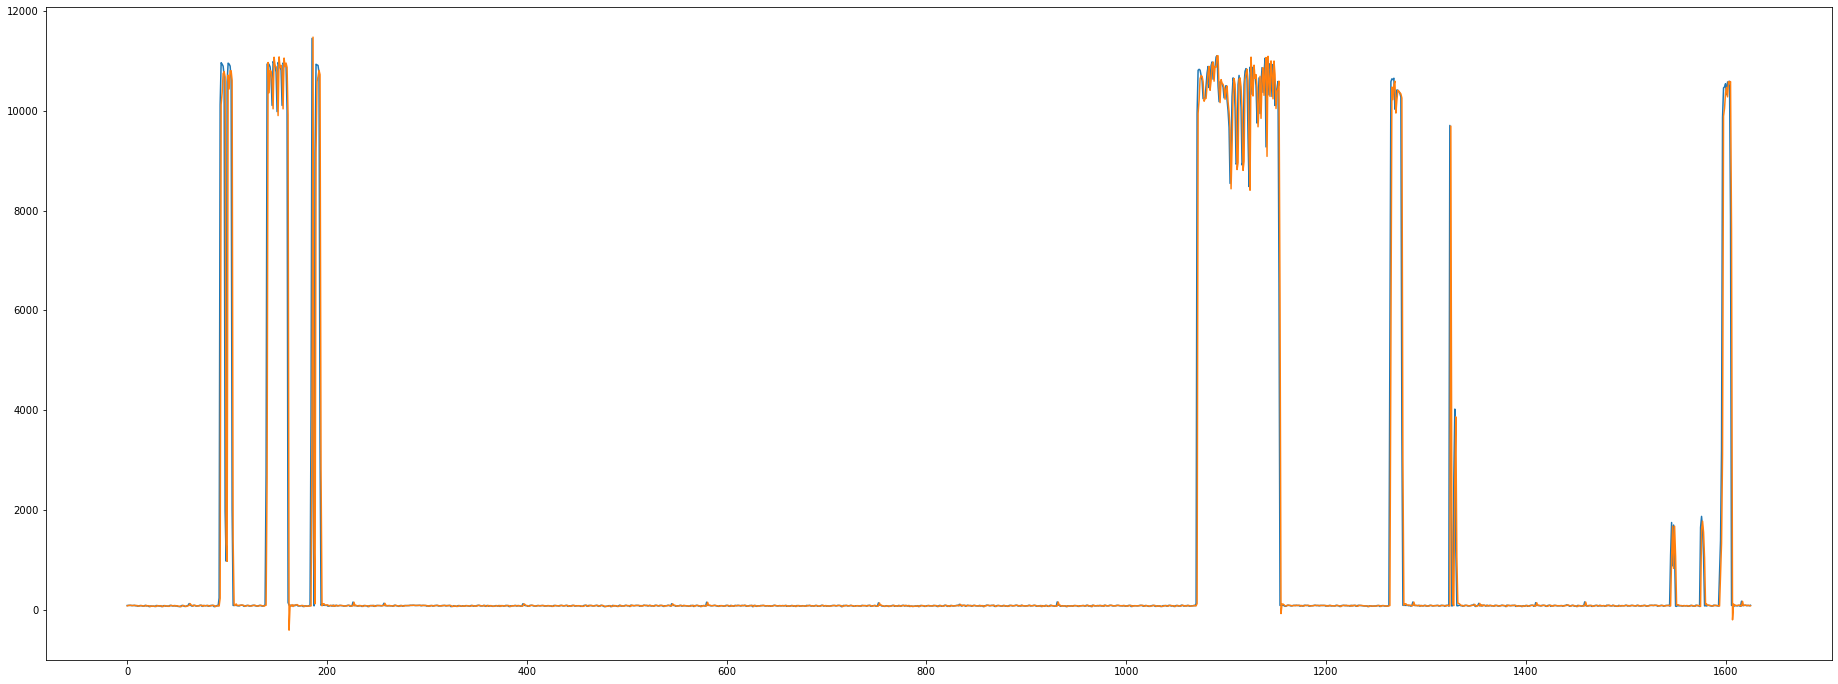

In [48]:
preds = model_GRU.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [49]:
# sayyiv le modele when done
model_GRU.save('./test_model_GPU')

INFO:tensorflow:Assets written to: ./test_model_GPU\assets


INFO:tensorflow:Assets written to: ./test_model_GPU\assets


In [50]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 927.76 RMSE
Test Score: 12.628815 MAE
Test Score: 36.867461 MAPE
